In [1]:
%matplotlib inline

import logging
import sys
import os
import glob

import math
import ogr
import shapely.geometry, shapely.wkt
import pylab
import matplotlib.pyplot as plt
from utils.shapely_plot import draw
import shapely as sl
import fiona
import numpy as np

pylab.rcParams['figure.figsize'] = (17.0, 15.0)
logging.basicConfig(stream=sys.stderr, level=logging.INFO)


In [2]:
# Clean-up shapefile and convert to KML

def get_geom_coord_count(geom):
    count = 0
  
    if type(geom) == shapely.geometry.multipolygon.MultiPolygon or type(geom) == shapely.geometry.multilinestring.MultiLineString:
        for g in geom.geoms:
            if type(g.boundary) == shapely.geometry.multipolygon.MultiPolygon or type(g.boundary) == shapely.geometry.multilinestring.MultiLineString:
                count += get_geom_coord_count(g.boundary)
            else:
                if type(g.boundary) == shapely.geometry.linestring.LineString or type(g.boundary) == shapely.geometry.polygon.Polygon:
                    count += len(g.boundary.coords)
        else:
            if type(geom.boundary) == shapely.geometry.linestring.LineString or type(g.boundary) == shapely.geometry.polygon.Polygon:
                count += len(geom.boundary.coords)
    if type(geom.boundary) == shapely.geometry.linestring.LineString or type(geom.boundary) == shapely.geometry.polygon.Polygon:
        count += len(geom.boundary.coords)
    
    return count

def convert(input_path):
    output_path = os.path.splitext(input_path)[0] + '.kml'

    filename = os.path.splitext(os.path.basename(input_path))[0]

    dst_ds = ogr.GetDriverByName('KML').CreateDataSource(output_path)
    dst_lyr = dst_ds.CreateLayer(filename)

    # create fields using OGR
    src_ds = ogr.Open(input_path)
    src_lyr = src_ds.GetLayerByIndex(0)
    f = src_lyr.GetFeature(0)
    [dst_lyr.CreateField(f.GetFieldDefnRef(i)) for i in range(f.GetFieldCount())]

    for feat in src_lyr:
        try:
            geom = shapely.wkt.loads(feat.GetGeometryRef().ExportToWkt())
        except Exception as e: 
            print('Error({0}), skipping geometry.'.format(e))
            continue

        #id = feat.GetField('HYBAS_ID')
        count = get_geom_coord_count(geom)

        # geom coord count
        # print('{0}: {1}'.format(id, count))

        if count > 10000:
            print ('simplifying ...')
            geom = geom.simplify(0.004)
        
        # uncomment in case of messed-up geometry
        #
        if not geom.is_valid:
            geom = geom.buffer(0.0)

        # geom = geom.simplify(0.004)

        # if id == 6030021870:
        #    print ('simplifying ...')
        #    geom = geom.simplify(0.004)

        f = ogr.Feature(dst_lyr.GetLayerDefn())

        # set field values
        for i in range(feat.GetFieldCount()):
            fd = feat.GetFieldDefnRef(i)
            f.SetField(fd.GetName(), feat.GetField(fd.GetName()))

        # set geometry    
        f.SetGeometry(ogr.CreateGeometryFromWkt(geom.to_wkt()))
        
        # create feature
        dst_lyr.CreateFeature(f)
        
        f.Destroy() 
        
    src_ds.Destroy()

    dst_ds.Destroy()

# files = glob.glob(r'D:\cloud\SURFdrive\reservoirs\Andijan\Andijan_cloud_free.shp')    
# files = glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_*_lev*_v1c.shp')
files = glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_na_lev03_v1c.shp')
# files = glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_sa_lev03_v1c.shp')


# files = glob.glob(r'D:\gis\HydroBASINS\without_lakes\simplified\hybas_au_lev08_v1c.shp')

# files = glob.glob(r'D:\gis\naturaleaqrth')
# files = glob.glob(r'D:\gis\GRanD\GRanD_dams_v1_1.shp')
# files = glob.glob(r'D:\gis\GRanD\GRanD_reservoirs_v1_1.shp')

# files = glob.glob(r'D:\gis\HydroBASINS\rivers\*_riv_15s.shp')
# files = [r'D:\gis\OpenStreetMaps\Asia\Australia\rivers_lines.shp',
#          r'D:\gis\OpenStreetMaps\Asia\Australia\rivers_multipolygons.shp']

# files = [r'D:\gis\OpenStreetMaps\simplified-land-polygons-complete-3857\simplified_land_polygons.shp']
    
# convert(r'D:\src\GitHub\data-utils\notebooks\shapefile.shp')

# convert(r'D:\gis\HydroBASINS\without_lakes\hybas_au_lev07_v1c.shp')

import sys

for f in files:
    print('Converting {0} ...'.format(f))
    sys.stdout.flush()

    convert(f)


Converting D:\gis\HydroBASINS\without_lakes\hybas_na_lev03_v1c.shp ...


simplifying ...
simplifying ...


simplifying ...


simplifying ...


simplifying ...

In [7]:
# just a dummy test code

import fiona

c = fiona.collection(files[0], "r")
print(c.schema)

type_map = { 'float' : ogr.OFTReal, 'int' : ogr.OFTInteger }

fields = c.schema['properties']
for p in fields:
    print p + ' ' + fields[p]

{'geometry': 'Polygon', 'properties': OrderedDict([(u'HYBAS_ID', 'float:11'), (u'NEXT_DOWN', 'float:11'), (u'NEXT_SINK', 'float:11'), (u'MAIN_BAS', 'float:11'), (u'DIST_SINK', 'float:10.1'), (u'DIST_MAIN', 'float:10.1'), (u'SUB_AREA', 'float:10.1'), (u'UP_AREA', 'float:10.1'), (u'PFAF_ID', 'int:8'), (u'ENDO', 'int:6'), (u'COAST', 'int:6'), (u'ORDER', 'int:6'), (u'SORT', 'float:11')])}
HYBAS_ID float:11
NEXT_DOWN float:11
NEXT_SINK float:11
MAIN_BAS float:11
DIST_SINK float:10.1
DIST_MAIN float:10.1
SUB_AREA float:10.1
UP_AREA float:10.1
PFAF_ID int:8
ENDO int:6
COAST int:6
ORDER int:6
SORT float:11


(-79.61249999999997, -20.479166666666636, -45.82499999999998, 5.283333333333359)


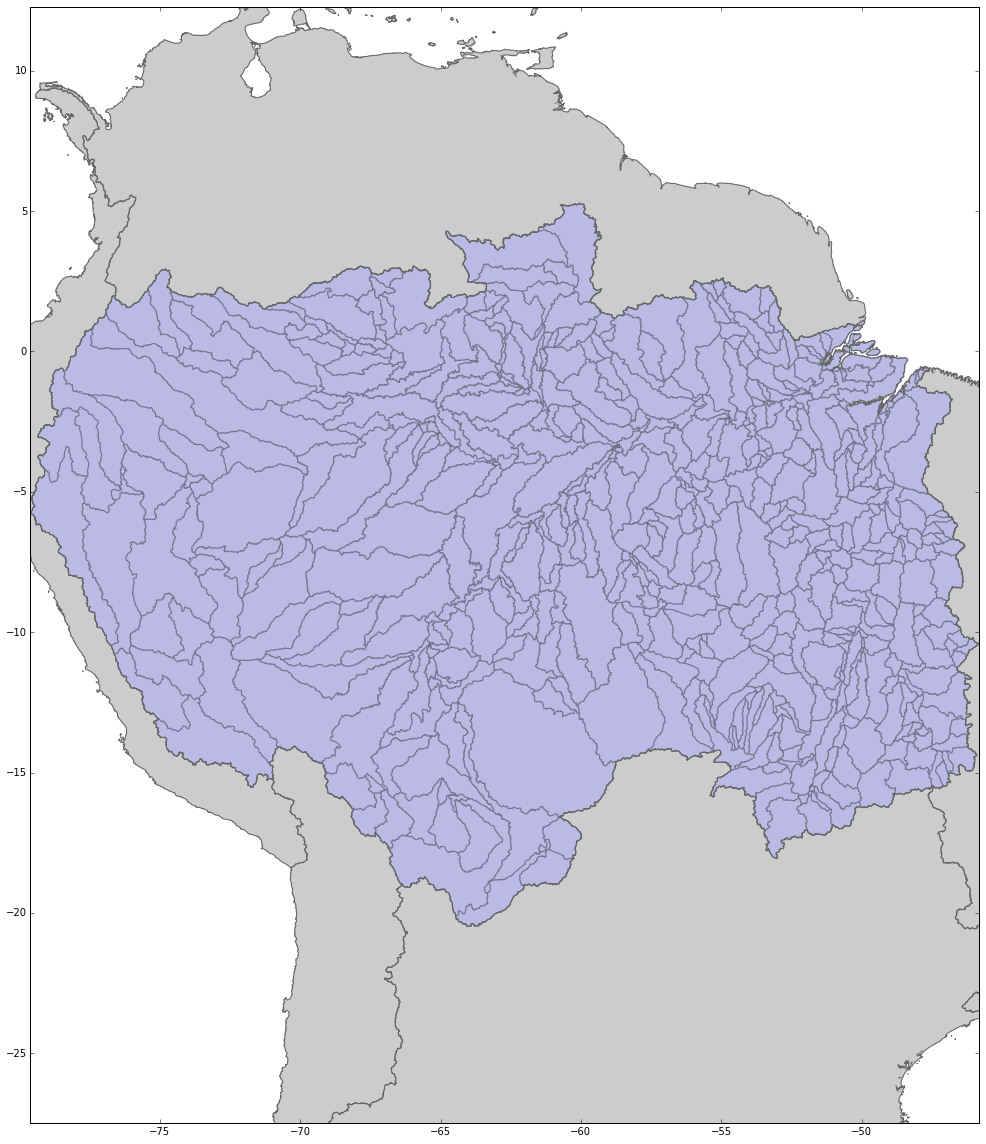

In [10]:
# TEST PLOT

# Select sub-basins that fall within a larger basin and then group them by using a regular grid

# Amazon
main_basin_shp = 'D:\gis\HydroBASINS\without_lakes\hybas_sa_lev02_v1c.shp'
main_basin_id = 6020006540
sub_basin_shp = 'D:\gis\HydroBASINS\without_lakes\hybas_sa_lev06_v1c.shp'

# Murray & Darling
# main_basin_shp = 'D:\gis\HydroBASINS\without_lakes\hybas_au_lev03_v1c.shp'
# main_basin_id = 5030073410
# sub_basin_shp = 'D:\gis\HydroBASINS\without_lakes\hybas_au_lev07_v1c.shp'

# Asia
# main_basin_shp = 'D:\gis\HydroBASINS\without_lakes\hybas_as_lev03_v1c.shp'
# main_basin_id = 4030022790
# sub_basin_shp = 'D:\gis\HydroBASINS\without_lakes\hybas_as_lev07_v1c.shp'
#

# North America
# main_basin_shp = 'D:\gis\HydroBASINS\without_lakes\hybas_na_lev02_v1c.shp'
# main_basin_id = 8010000010
# sub_basin_shp = 'D:\gis\HydroBASINS\without_lakes\hybas_na_lev07_v1c.shp'

pylab.rcParams['figure.figsize'] = (17.0, 20.0)

fig = plt.figure()
axes = plt.axes()
axes.set_aspect('equal', 'datalim')

main_basin_geom = None

with fiona.collection(main_basin_shp, "r") as input:
    for f in input:
        geom = sl.geometry.shape(f['geometry'])

        id = f['properties']['HYBAS_ID']
        if id == main_basin_id:
            main_basin_geom = geom
        draw(geom)

bounds = main_basin_geom.bounds
axes.set_xlim(bounds[0], bounds[2])
axes.set_ylim(bounds[1], bounds[3])

print(bounds)
                                
with fiona.collection(sub_basin_shp, "r") as input:
    for f in input:
        geom = sl.geometry.shape(f['geometry'])

        if main_basin_geom.contains(geom):
            draw(geom, fill='#aaaaff', alpha=0.5)
        else:
            pass
            # draw(geom, fill='#ffffff', lw=0.1)

plt.show()  
